<a href="https://colab.research.google.com/github/davidfox87/neuro_encoding_models/blob/master/ankita_fit_temporal_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Clone the github repository 
!git clone https://github.com/davidfox87/neuro_encoding_models

Cloning into 'neuro_encoding_models'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 722 (delta 66), reused 49 (delta 23), pack-reused 598
Receiving objects: 100% (722/722), 89.31 MiB | 18.24 MiB/s, done.
Resolving deltas: 100% (412/412), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
% ls -la /content/drive/MyDrive/temporal_filter_data_files_for_colab/

total 313944
-rw------- 1 root root  8160737 Nov 18 15:09 angvturns_out.pkl
-rw------- 1 root root  1249862 Nov 19 22:10 average_neural_data.pkl
-rw------- 1 root root   880220 Nov 18 16:04 basis.pkl
-rw------- 1 root root   336456 Feb  2 13:52 ConstantAir_glom1.mat
-rw------- 1 root root 74060867 Nov 29 12:14 control_stim_to_behavior_forward.mat
-rw------- 1 root root 70166534 Nov 17 17:22 control_stim_to_behavior.mat
-rw------- 1 root root   513822 Nov 29 13:23 controlupwindfilter_forward.out
-rw------- 1 root root   518601 Nov 29 11:31 controlupwindfilter.out
-rw------- 1 root root     5042 Nov 29 14:32 controlupwind_gain_forward.out
-rw------- 1 root root     5088 Nov 29 14:15 controlupwind_gain_reverse.out
-rw------- 1 root root   186532 Nov 29 13:14 forwardChirpStim.txt
-rw------- 1 root root  1606613 Dec  1 08:57 master_filter_summary.eps
drwx------ 2 root root     4096 Nov 18 16:39 ORN/
drwx------ 2 root root     4096 Nov 18 16:36 PN/
-rw------- 1 root root   992724 Nov 18 15:4

In [3]:
%cd neuro_encoding_models/

/content/neuro_encoding_models


In [4]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [12]:
#@title import modules
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge
import utils.read as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from glmtools.fit import fit_nlin_hist1d
import pickle
from utils.read import load_ankita_data
from sklearn.model_selection import KFold
from glmtools.make_xdsgn import Experiment, DesignSpec
from sklearn.metrics import r2_score, mean_squared_error
from joblib import Parallel, delayed

In [6]:
#@title helper functions

def make_dspec(stim, response, dt, inds):
	# make an Experiment object
	expt = Experiment(dt, len(stim)*dt, stim=stim, response=response)

	# register continuous regressor
	expt.registerContinuous('stim')

	# initialize design spec with number of entries
	return DesignSpec(expt, trialinds=inds)

In [7]:
dt = 1. / 25.
filepath = '/content/drive/MyDrive/temporal_filter_data_files_for_colab/ConstantAir_glom1.mat'
stims, responses = load_ankita_data(filepath)

inds = np.arange(stims.shape[1])
train_inds, test_inds = train_test_split(inds, test_size=0.2, random_state=42)
X_train, X_test = stims[:, train_inds], stims[:, test_inds]
y_train, y_test = responses[:, train_inds], responses[:, test_inds]



In [8]:
ntrials = X_train.shape[1]
inds = np.arange(ntrials)  # trial indices used to make splits
np.random.shuffle(inds)

In [9]:
	folds_xtrain = []
	folds_xtest = []
	folds_ytrain = []
	folds_ytest = []

	kf = KFold(n_splits=5)
	kf.get_n_splits(inds)

	scaler = StandardScaler()
	scaler2 = MinMaxScaler([0, 1])
	X_train = scaler.fit_transform(X_train)
	y_train = scaler2.fit_transform(y_train)

In [10]:
	for train_index, val_index in kf.split(inds):
		# each fold will consist of a design matrix that will have concatenated trials for that fold
		# e.g. the first fold will train on trials 1, 2, 3 and test on 0
		# the second fold will train on 0, 2, 3 and test on 1
		print("TRAIN:", train_index, "VALIDATION:", val_index)

		train_dspec = make_dspec(X_train[:, train_index], y_train[:, train_index], dt, np.arange(len(train_index)))
		train_dspec.addRegressorContinuous()

		# use the inds to take a slice of sps and make a test design matrix
		test_dspec = make_dspec(X_train[:, val_index], y_train[:, val_index], dt, np.arange(len(val_index)))
		test_dspec.addRegressorContinuous()

		dm, Xtrain, ytrain = train_dspec.compileDesignMatrixFromTrialIndices(bias=1)
		dm, Xtest, ytest = test_dspec.compileDesignMatrixFromTrialIndices(bias=1)

		# Xtrain = scaler.fit_transform(Xtrain)
		# Xtest = scaler.transform(Xtest)		# transform Xtest to the same scale as Xtrain

		folds_xtrain.append(Xtrain)
		folds_xtest.append(Xtest)
		folds_ytrain.append(ytrain)
		folds_ytest.append(ytest)


	print('done making folds')


  0%|          | 0/35 [00:00<?, ?it/s]

TRAIN: [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42] VALIDATION: [0 1 2 3 4 5 6 7 8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42] VALIDATION: [ 9 10 11 12 13 14 15 16 17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42] VALIDATION: [18 19 20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 35 36 37 38 39 40 41 42] VALIDATION: [27 28 29 30 31 32 33 34]


100%|██████████| 8/8 [00:00<00:00, 1401.31it/s]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] VALIDATION: [35 36 37 38 39 40 41 42]
done making folds


In [13]:
def ridgefitCV(train, test, parameter):
  msetest_fold = 0
  for train, test in zip(train, test):
    Xtrain, ytrain = train
    Xtest, ytest = test

    model = Ridge(alpha=parameter).fit(Xtrain, ytrain)

    msetest_fold += mean_squared_error(ytest, model.predict(Xtest))

  # take the average mse across folds for this alpha
  return msetest_fold / len(train)


lamvals = np.logspace(-5, 5, num=20, base=2)


def _run_search(evaluate_candidates):
  """Search all candidates in param_grid"""
  evaluate_candidates(lamvals)


parallel = Parallel(n_jobs=10, verbose=10)

all_out = []

with parallel:

  def evaluate_candidates(candidate_params):
    out = parallel(delayed(ridgefitCV)(train=zip(folds_xtrain, folds_ytrain),
                        test=zip(folds_xtest, folds_ytest),
                        parameter=param)
              for param in candidate_params)

    all_out.extend(out)

_run_search(evaluate_candidates)

print(all_out)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    4.2s remaining:   16.7s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    5.6s remaining:   10.3s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    7.4s remaining:    4.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    7.7s remaining:    1.9s


[0.0338252669612299, 0.03382526607074102, 0.03382526478964673, 0.03382526294751703, 0.03382526030053169, 0.033825256500922524, 0.03382525105482322, 0.03382524326537992, 0.03382523215860943, 0.033825216392416625, 0.03382519415727159, 0.03382516309591045, 0.0338251203093142, 0.03382506259423246, 0.03382498719836005, 0.0338248936100273, 0.03382478723121022, 0.03382468617997673, 0.033824632836706656, 0.0338247120291669]


[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    8.0s finished


best ridge param is 22.218418281834488


22.218418281834488

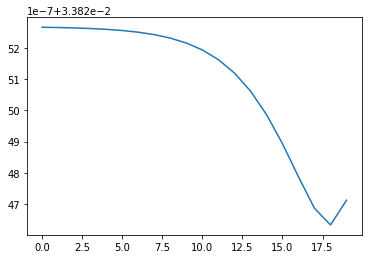

In [14]:

imin = np.argmin(all_out)
print("best ridge param is {}".format(lamvals[imin]))
plt.plot(all_out)


lamvals[imin]

100%|██████████| 35/35 [00:00<00:00, 1786.68it/s]


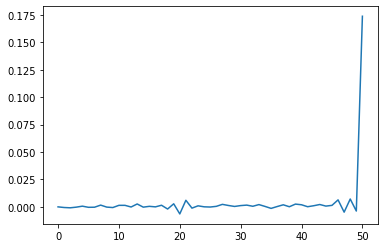

In [15]:
# run ridge with the best alpha on the average response

dspec = make_dspec(X_train, y_train, dt, np.arange(X_train.shape[1]))
dspec.addRegressorContinuous()
dm, X, y = train_dspec.compileDesignMatrixFromTrialIndices(bias=1)

model = Ridge(alpha=lamvals[imin]).fit(X, y)

w = model.coef_
plt.plot(w)


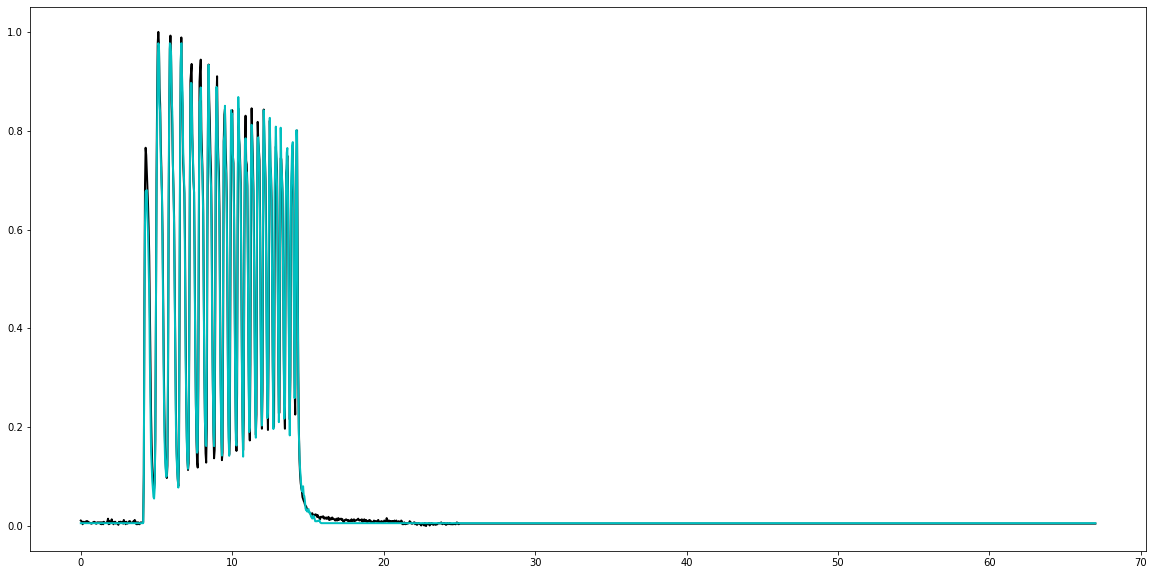

In [17]:

d = dm.get_regressor_from_output(w)

# # convert back to the original basis to get nkt filter weights.
# # Parameters are returned in a dict
dc = w[0]
k = d['stim'][1]
kt = d['stim'][0] * dt


X_test = scaler.fit_transform(X_test)
y_test = scaler2.fit_transform(y_test)

idx = 10
input = X_test[:, idx]
output = y_test[:, idx]
xx, fnlin, rawfilteroutput = fit_nlin_hist1d(input, output, k, dt, 20)

Fs = 25
t = np.arange(0, len(X_test[:, idx])) / Fs
plt.figure(figsize=[20, 10])
plt.plot(t, output, 'k', linewidth=2)
plt.plot(t, fnlin(rawfilteroutput), 'c', linewidth=2)